# Sparse Gaussian Processes
While the Gaussian Process is a powerful tool used in Databased modeling, it struggles with large Datasets, as the prediction step requires inverting the Matrix K(x,x), which is $O(n^{3})$. So for cases like the PDE equation that im dealing with, this straightforward approach is no longer feasible. 
What can be done instead is using so called "pseudo-inputs", that are fewer in number than the original Datasets . These inputs are also part of the optimization and they do not necessariliy have to align with the measured datapoints. This [Paper](https://papers.nips.cc/paper_files/paper/2005/hash/4491777b1aa8b5b32c2e8666dbe1a495-Abstract.html) covers the theoretical background. 

In [3]:
#imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
from functools import partial
import pickle
import torch
import gpytorch
import torch.nn as nn
from Training_helper import *
import pandas as pd
%load_ext autoreload
%autoreload 2

# Data import

In [4]:
with open("Dataset_training_integro_diff_Batch.pkl", "rb") as f:
    Dataset = pickle.load(f)


first = next(iter(Dataset.values()))
M, T = first["n"].shape
dim=M+1  # +1 for S
t_span=(0,0.1*T)
t_eval= torch.linspace(*t_span,T)
m=torch.linspace(0,2e-10,M, dtype=torch.float32)
delta_m=(m[1]-m[0]).item()
m_max=m[-1]

n_max = max(torch.tensor(entry["n"], dtype=torch.float32).max() for entry in Dataset.values())
S_max = 5   #max possible substrate

X_all, Y_all = [], []

for entry in Dataset.values():
    n = torch.tensor(entry["n"], dtype=torch.float32)  # (M, T)
    s = torch.tensor(entry["S"], dtype=torch.float32)  # (T,)

    n_norm = n / n_max#torch.log1p(n) / log_n_max                # log scaling
    s_norm = s / S_max         

    # X_t = [n(t), s(t)]
    X = torch.cat([n_norm[:, :-1], s_norm[:-1].unsqueeze(0)], dim=0).T   # shape (T-1, M+1)
    # Y_t = [n(t+1), s(t+1)]
    Y = torch.cat([n_norm[:, 1:],  s_norm[1:].unsqueeze(0)], dim=0).T    # shape (T-1, M+1)

    X_all.append(X)
    Y_all.append(Y)

# final stacked tensors
X_train = torch.cat(X_all, dim=0)  # shape: (total_samples, M+1)
Y_train = torch.cat(Y_all, dim=0)  # shape: (total_samples, M+1)


#validation set containing 1 dataset used for plotting
with open("Dataset_validation_integro_diff_Batch_for_plots.pkl", "rb") as f:
    Dataset_validation = pickle.load(f)

n0 = torch.tensor(Dataset_validation[0]["n"][:, 0], dtype=torch.float32)   # (M,)
S0 = torch.tensor(Dataset_validation[0]["initial_substrate"], dtype=torch.float32)

#validation set containing 147 datasets used for error estimation over a broad range of parameters
with open("Dataset_validation_integro_diff_Batch.pkl","rb") as f:
    Dataset_error_est=pickle.load(f)


# Building the Multitask GP

In [6]:
X = X_train.float()
Y = Y_train.float()

N, D = X.shape
num_tasks = Y.shape[1]

# --- Likelihood for multitask regression
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

class SparseLMCMultitaskGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_tasks: int, num_latents: int = 3):
        """
        inducing_points: (num_latents, M, D)
        """
        # Variational distribution & strategy over inducing points (batched by num_latents)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2),  # M
            batch_shape=torch.Size([inducing_points.size(0)])  # = num_latents
        )
        base_variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,                      # (num_latents, M, D)
            variational_distribution,
            learn_inducing_locations=True,
        )

        # Wrap with LMC to mix latents -> tasks
        lmc_strategy = gpytorch.variational.LMCVariationalStrategy(
            base_variational_strategy,
            num_tasks=num_tasks,
            num_latents=inducing_points.size(0),  # = num_latents
            latent_dim=-1,                        # latents live in the leading batch dim
        )
        super().__init__(lmc_strategy)

        # Mean & kernel must also be batched by num_latents
        batch_shape = torch.Size([inducing_points.size(0)])   # = [num_latents]
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=D, batch_shape=batch_shape),
            batch_shape=batch_shape
        )

    def forward(self, x):
        # mean_x, covar_x each have batch_shape = [num_latents]
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ----- Inducing points: (num_latents, M, D)
num_latents = 12                 # increase if tasks are complex/heterogeneous
M = 128                         # inducing points per latent
perm = torch.randperm(N)[:M]
Z_one = X[perm]                 # (M, D)
inducing_points = Z_one.unsqueeze(0).repeat(num_latents, 1, 1)  # (num_latents, M, D)

model = SparseLMCMultitaskGP(inducing_points, num_tasks=num_tasks, num_latents=num_latents)
print(inducing_points.shape)

torch.Size([12, 128, 101])


In [ ]:

# ----- Training
model.train()
likelihood.train()

# ELBO needs the number of data points, not numel
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=N)

# optionally use natural gradients for the variational params (often helps)
from gpytorch.optim import NGD
variational_optimizer = NGD(model.variational_parameters(), num_data=N, lr=0.1)
hyper_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()}
], lr=0.01)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.01)

training_iter = 1000
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X)             # MultitaskMultivariateNormal with event_shape (N, num_tasks)
    loss = -mll(output, Y)        # Y shape (N, num_tasks)
    loss.backward()
    if (i + 1) % 25 == 0:
        print(f"Iter {i+1:03d}/{training_iter}  ELBO: {-loss.item():.3f}")
    optimizer.step()

# # ----- Prediction (on X itself or X_test)
# model.eval()
# likelihood.eval()
# with torch.no_grad():
#     pred = likelihood(model(X))        # MultitaskMultivariateNormal
#     mean = pred.mean                   # (N, num_tasks)
#     lower, upper = pred.confidence_region()  # each (N, num_tasks)

# print("mean[0,:5] =", mean[0, :5])



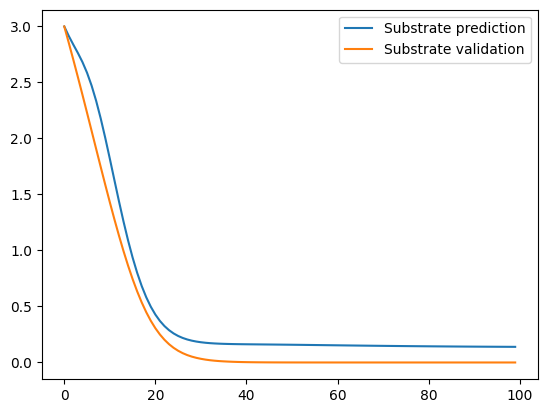

In [29]:


def norm_input_GP(n_vec, S_scalar, n_max, S_max):
    """
    n_vec: (M,)    in original units
    S_scalar: ()   in original units (tensor or float)
    returns X_norm: (1, M+1) float32
    """
    if not torch.is_tensor(S_scalar):
        S_scalar = torch.tensor(S_scalar, dtype=n_vec.dtype)
    x_norm = torch.cat([n_vec / n_max, (S_scalar / S_max).view(1)], dim=0).unsqueeze(0)
    return x_norm.float()

def split_and_denorm_cpu(y_norm_row, n_max, S_max, M):
    """
    y_norm_row: (M+1,) normalized prediction
    returns (n_next, S_next) in original units
    """
    n_next = y_norm_row[:M] * n_max
    S_next = y_norm_row[-1] * S_max
    return n_next, S_next

@torch.no_grad()
def predict_one_step_cpu(model, likelihood, n_t, S_t, n_max, S_max):
    """
    One-step: [n(t), S(t)] -> predict [n(t+1), S(t+1)].
    Inputs/outputs in ORIGINAL units.
    """
    model.eval(); likelihood.eval()
    X_in = norm_input_GP(n_t, S_t, n_max, S_max)     # (1, M+1)
    pred = likelihood(model(X_in))                # Multitask MVN, event_shape=(1, M+1)

    mean = pred.mean.squeeze(0)                   # (M+1,)
    # If you need uncertainty:
    # var  = pred.variance.squeeze(0)             # (M+1,) in normalized units
    # n_var = var[:-1] * (n_max**2)
    # S_var = var[-1]   * (S_max**2)

    M_bins = n_t.numel()
    n_next, S_next = split_and_denorm_cpu(mean, n_max, S_max, M_bins)
    return n_next, S_next

@torch.no_grad()
def rollout_cpu(model, likelihood, n0, S0, steps, n_max, S_max):
    """
    Autoregressive rollout for 'steps' steps starting from (n0, S0).
    Returns:
      Ns: (M, steps+1) including the initial state
      Ss: (steps+1,)
    """
    model.eval(); likelihood.eval()
    n_t = n0.clone().float()
    S_t = (S0.clone().float() if torch.is_tensor(S0) else torch.tensor(S0, dtype=n_t.dtype))

    M_bins = n_t.numel()
    Ns, Ss = [n_t.clone()], [S_t.clone()]

    for _ in range(steps):
        n_next, S_next = predict_one_step_cpu(model, likelihood, n_t, S_t, n_max, S_max)
        n_t, S_t = n_next, S_next
        Ns.append(n_t.clone())
        Ss.append(S_t.clone())

    Ns = torch.stack(Ns, dim=1)     # (M, steps+1)
    Ss = torch.stack(Ss)            # (steps+1,)
    return Ns, Ss



T_steps = Dataset_validation[0]["n"].shape[1] - 1

# run rollout
n_roll, S_roll = rollout_cpu(model, likelihood, n0, S0, steps=T_steps, n_max=n_max, S_max=S_max)
plt.plot(S_roll,label="Substrate prediction")
plt.plot(Dataset_validation[0]['S'],label= "Substrate validation")
plt.legend(loc='best')
plt.show()

plot_spaghetti(m=m,t=t_eval,N=n_roll.detach().numpy())

In [ ]:
model.eval()

torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict(),
}, "Sparse_Mulittask_GP_12_latents.pth")

